# Epitope prediction workflow for M.bovis (part 1) 
## EMIDA antigen mining project

### Reference:

**Integrated computational prediction and experimental validation identifies promiscuous T cell epitopes in the proteome of pathogenic mycobacteria.** Damien Farrell, Gareth Jones, Chris Pirson, Kerri M Malone, Kevin Rue-Albrecht, Anthony J Chubb, H Martin Vordermeier, Stephen V. Gordon. 2016

We apply several binding prediction methods to the M. bovis proteome using a subset of human HLA alleles to approximate the bovine immune response. Two different strategies are then applied to filter the resulting set of binders: global binder ranking and epitope density. Several other metrics are applied to produce a final list of peptide candidates.

Contact:

Tuberculosis Molecular Microbiology group,
School of Veterinary Medicine,  
University College Dublin,  
Dublin 4.  

### Requires:

Old version of mhcpredict library, needs to be updated.

pandas, matplotlib, seaborn

In [1]:
import os,sys
import re
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
home = os.path.expanduser('~')
#we still need the older version of the module for repeating the original work
sys.path.append(os.path.join(home,'python/sandbox/mhcpredict'))
import Base, Genome, Tepitope, EpitopePipeline
from matplotlib_venn import venn2,venn3
pd.set_option('display.width', 100)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth',80)
import seaborn as sns
sns.set_style("ticks", {'axes.facecolor': '#F7F7F7','axes.grid': False,'legend.frameon':True, 'legend.fontsize':12})
sns.set_context("notebook", font_scale=1.4)
plt.rcParams['savefig.dpi']=150
from IPython.display import display, HTML
#newer module version we use for remainder of analysis
from epitopepredict import base, analysis, sequtils, utilities

modeller not installed


In [2]:
genome = sequtils.genbank2Dataframe('MTB-H37Rv.gb', cds=True)
mbovis = sequtils.genbank2Dataframe('Mbovis.gb', cds=True)

In [8]:
#srm data
srm = pd.read_csv('srm_mtb.csv')
srm = genome.merge(srm[['locus_tag','concentration']],on='locus_tag',how='inner')
srm = srm[srm.concentration>0]
print len(srm)
#srm = srm[srm.length<=400]
#print len(srm)

1870


In [9]:
n=3
minsize=2
mhc1alleles = ['BoLA-N:00101','BoLA-N:00201','BoLA-N:00301','BoLA-N:00401',
                 'BoLA-N:00501','BoLA-N:00601','BoLA-N:00801','BoLA-N:00901',
                 'BoLA-N:01001']
otherbinders = {}
otherbinders['iedbmhc1_9'] = pd.read_csv('binders_MTB-H37Rv_iedbmhc1_9_3.csv')
otherbinders['iedbmhc1_11'] = pd.read_csv('binders_MTB-H37Rv_iedbmhc1_11_3.csv')
otherbinders['tepitope'] = pd.read_csv('binders_MTB-H37Rv_tepitope_bovine_3.csv')
otherbinders['netmhciipan'] = pd.read_csv('binders_MTB-H37Rv_netmhciipan_bovine_3.csv')
mapping = pd.read_csv('mbovis_mapping_new.csv',usecols=[1,2,3,4])#,index_col=0)

#show filtered numbers (done inside the pipeline)
for n in otherbinders:    
    d=otherbinders[n]
    dsrm = d.merge(srm[['locus_tag','length']],left_on='name',right_on='locus_tag')
    print n, len(d), len(dsrm), len(dsrm[dsrm.length>400])

iedbmhc1_9 45480 22458 12388
iedbmhc1_11 47500 23203 12746
netmhciipan 27155 14152 7584
tepitope 47370 24172 13004


In [116]:
#netmhciipan different binder lengths
n=3
m='netmhciipan'
gname='MTB-H37Rv'
l1='bovine'
l2='bovine_11'
l3='bovine_15'
file1 = 'binders_%s_%s_%s_%s.csv' %(gname,m,l1,n)
file2 = 'binders_%s_%s_%s_%s.csv' %(gname,m,l2,n)
file3 = 'binders_%s_%s_%s_%s.csv' %(gname,m,l3,n)
b1 = pd.read_csv(file1,index_col=0)
b2 = pd.read_csv(file2,index_col=0)
b3 = pd.read_csv(file3,index_col=0)

In [117]:
EpitopePipeline=reload(EpitopePipeline)
#cl1 = EpitopePipeline.findClusters(b1,m,minsize=minsize)
#n9 = EpitopePipeline.analyseClusters(cl1, genome, gname, m, otherbinders, l=9)
n9 = pd.read_csv('result_%s_%s_9.csv' %(gname,m))

In [118]:
print file1
cols=['locus_tag','R','binders','clustersize','start','end','peptide','RVL','mbname','identity']
print n9[cols][:5]
#print n9.drop_duplicates('peptide')[cols]
#print n9[n9.RVL<=0.35][cols]

binders_MTB-H37Rv_netmhciipan_bovine_3.csv
  locus_tag       R  binders  clustersize  start  end               peptide   RVL   mbname  \
0    Rv1240  23.495        3           13     18   31  GQIGYSLLFRLASGSLLGPD  0.30   Mb1272   
1   Rv1886c  19.799        2           10      6   16  MTDVSRKIRAWGRRLMIGTA  0.30  Mb1918c   
2   Rv2995c  18.974        2           10     92  102  RFELDHHINLRPARLYPGVA  0.35  Mb3019c   
3   Rv2185c  17.748        3           16     52   68  KRARMLMDAAIFKDTLIMSY  0.20  Mb2207c   
4   Rv1886c  17.146        2           10    270  280  PAEFLENFVRSSNLKFQDAY  0.20  Mb1918c   

   identity  
0     100.0  
1     100.0  
2      99.7  
3     100.0  
4     100.0  


In [25]:
EpitopePipeline=reload(EpitopePipeline)
#cl2 = EpitopePipeline.findClusters(b2,m,minsize=minsize)
#n11 = EpitopePipeline.analyseClusters(cl2, genome, gname, m, otherbinders, l=11)
n11 = pd.read_csv('result_%s_%s_11.csv' %(gname,m))

In [26]:
print file2
print n11[cols][:5]
#print n11.peptide.str.len()

binders_MTB-H37Rv_netmhciipan_bovine_11_3.csv
  locus_tag       R  binders  clustersize  start  end               peptide   RVL   mbname  \
0   Rv2995c  18.974        2           12     91  103  RFELDHHINLRPARLYPGVA  0.35  Mb3019c   
1    Rv1484  12.000        2           18     13   31  VSGIITDSSIAFHIARVAQE  0.15   Mb1520   
2   Rv3161c  10.583        2           15    360  375  KEWPGMLAFYRNLAMALVGD  0.25  Mb3186c   
3    Rv1827  10.000        2           12     85   97  RHPDSDIFLDDVTVSRRHAE  0.30   Mb1858   
4    Rv3846   9.592        2           18    164  182  EHAFYLQYKNVKVDFAKAFW  0.15   Mb3876   

   identity  
0      99.7  
1     100.0  
2      99.7  
3     100.0  
4      99.5  


In [27]:
#cl3 = EpitopePipeline.findClusters(b3,m,minsize=minsize)
#n15 = EpitopePipeline.analyseClusters(cl3, genome, gname, m,otherbinders, l=15)
n15 = pd.read_csv('result_%s_%s_15.csv' %(gname,m))

In [28]:
cols1=['locus_tag','R','binders','clustersize','start','end','peptide','mbname','identity']
print file3
print n15[cols1][:5]

binders_MTB-H37Rv_netmhciipan_bovine_15_3.csv
  locus_tag       R  binders  clustersize  start  end               peptide   mbname  identity
0   Rv2460c  20.298        2           16    128  144  ALPNARVLIHQPSLSGVIQG  Mb2487c       100
1    Rv2296  12.728        2           16     57   73  EPTWSYLYRTMIPPLSAAGH   Mb2318       100
2    Rv1594  10.583        2           16    298  314  DRASCKYMKMITPAALLRCL   Mb1620       100
3    Rv1296   9.165        2           18    246  264  AAMTASAEYLRLLRRHNVAA   Mb1328       100
4    Rv2715   9.000        3           17    140  157  VTKDVNIVFRLASLPMGSEA   Mb2734       100


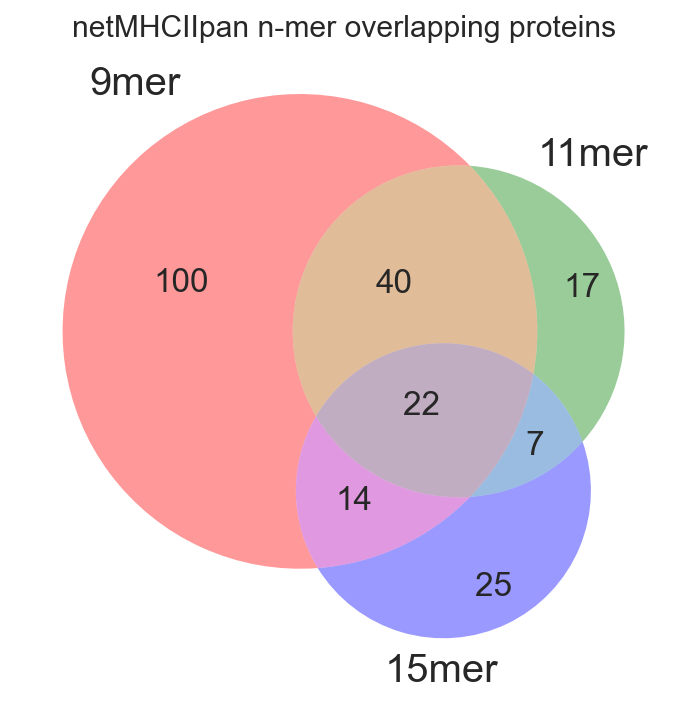

In [29]:
plt.rcParams['font.size']=16
venn3([set(n9.locus_tag),set(n11.locus_tag),set(n15.locus_tag)],set_labels=['9mer','11mer','15mer'])
plt.title('netMHCIIpan n-mer overlapping proteins')
#set(res1[:50].locus_tag) & set(res2[:50].locus_tag)

In [119]:
EpitopePipeline=reload(EpitopePipeline)
mt='tepitope'
file4 = 'binders_%s_%s_%s_%s.csv' %(gname,mt,l1,3)
b4 = pd.read_csv(file4,index_col=0)
#cl4 = EpitopePipeline.findClusters(b4,mt,minsize=minsize)
#t = EpitopePipeline.analyseClusters(cl4, genome, gname, mt,otherbinders)
t = pd.read_csv('result_%s_%s_9.csv' %(gname,mt))

### process cluster results into final files

In [31]:
#combine n11 and n15
nfinal = EpitopePipeline.combineResults(n15,n11)
both = t.merge(nfinal,on='locus_tag')
ovlps = both[abs(both.start_x-both.start_y)<4][['locus_tag','start_x','start_y','peptide_x','peptide_y']]
print len(t[t.locus_tag.isin(ovlps.locus_tag)]), 'overlaps'

#get rid of tepitope peptides that are also in netmhciipan results
tfinal = t[-t.locus_tag.isin(ovlps.locus_tag)].reset_index()
#tfinal=t
print 'final results: %s netmhciipan and %s tepitope' %(len(nfinal), len(tfinal))
fcols=['locus_tag','mbname','identity','R','binders','clustersize','start','end', 'peptide','peplength',
       'concentration','hydro','RVL','source','gene','order','product',
       'iedbmhc1_9_overlap','iedbmhc1_11_overlap','mhc1overlaps']
nfinal[fcols].to_csv('result_MTB-H37Rv_netmhciipan_final.csv')
tfinal[fcols].to_csv('result_MTB-H37Rv_tepitope_final.csv')

#venn3([set(t.locus_tag),set(n11.locus_tag),set(n15.locus_tag)],
#      set_labels=['tepitope','netMHCIIpan 11mer','netMHCIIpan 15mer'],alpha=0.6)
#plt.savefig('cluster_overlaps.png')

22 overlaps
final results: 131 netmhciipan and 102 tepitope


/home/farrell/python/sandbox/mhcpredict/EpitopePipeline.py:1134: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  final=final.sort('R',ascending=False).reset_index(drop=True)


In [ ]:
#summary of binders/clusters?
print len(b2),len(b3),len(b4)
print len(n11),len(n15),len(t)
f,ax=plt.subplots(1,1,figsize=(8,4))
ind=np.arange(0,3)
ln1=ax.bar(ind,[len(b2),len(b3),len(b4)],width=0.4)
ax1=plt.twinx(ax)
ln2=ax1.bar(ind+.5,[len(n11),len(n15),len(t)],width=0.4,color='lightblue')
names=['netMHCIIpan 11mer','netMHCIIpan 15mer','tepitope']
ax.set_xticks(ind+.5)
ax.set_xticklabels(names, minor=False, fontsize=15)
ax.set_ylabel('total binders')
ax1.set_ylabel('filtered clusters')
plt.legend([ln1,ln2],['binders','clusters'])

### get top shared binders

In [121]:
n=3
mhc1binders={}
biedb1 = mhc1binders['iedbmhc1_11'] = pd.read_csv('binders_MTB-H37Rv_iedbmhc1_11_3.csv')
biedb2 = mhc1binders['iedbmhc1_9'] = pd.read_csv('binders_MTB-H37Rv_iedbmhc1_9_3.csv')
EpitopePipeline=reload(EpitopePipeline)
shared = EpitopePipeline.getProteinswithSharedBinders(gname, l1, genome, n=n, otherbinders=mhc1binders)
shared['mhc1overlaps'] = shared.filter(regex="iedbmhc1_").sum(axis=1)
scols = ['locus_tag','mbname','peptide','start','end','rank','iedbmhc1_11_overlap','iedbmhc1_9_overlap']
print shared.sort('locus_tag')[55:65][scols]
print len(shared)

------top shared binder proteins------
read file binders_MTB-H37Rv_tepitope_bovine_3.csv
read file binders_MTB-H37Rv_netmhciipan_bovine_3.csv
8834 shared binders found
239 proteins with top shared binders

/home/farrell/python/sandbox/mhcpredict/EpitopePipeline.py:307: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  best.sort(['rank'],inplace=True)
/home/farrell/python/sandbox/mhcpredict/EpitopePipeline.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[label] = df.apply(lambda r: overlap(r,b),axis=1)



39 known antigens in results
overlaps for iedbmhc1_9
244 with overlapping binders
overlaps for iedbmhc1_11
222 with overlapping binders
454 peptide candidates in 237 proteins after peptide filtering

/home/farrell/python/sandbox/mhcpredict/EpitopePipeline.py:352: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  result = result.sort(['rank','locus_tag']).reset_index()
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:9: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)



    locus_tag   mbname               peptide  start  end  rank  iedbmhc1_11_overlap  iedbmhc1_9_overlap
157   Rv0500A   Mb0512  VAEVAALMRVSKMTVYRLVH     26   46   299                    1                   0
158   Rv0500A   Mb0512  VRVGRSFRVHAKAVHDMLET     52   72   299                    1                   0
400   Rv0503c  Mb0515c  SNEFFKLWLDPSMTYSCAYF     26   46   498                    1                   1
451   Rv0533c  Mb0547c  SGPRPFVRLEGPAVFRWAAF    212  232   696                    1                   0
378    Rv0577   Mb0592      DPQGAIFSVLKPAPQQ    245  265   461                    0                   0
8     Rv0580c  Mb0595c  HPPAALLRLVNPILRSLLHT     11   31   107                    2                   1
7     Rv0580c  Mb0595c  TAMRGELIRDRAVVSELFLR     94  114   107                    0                   0
150   Rv0632c  Mb0649c  ALEIMKLRLTRSAYQQATGL    140  160   288                    0                   1
205    Rv0635   Mb0654  TAEAQIVQVDQVLKFEKPIV     78   98   319 

In [ ]:
#check our mhc 1 predictions and overlaps!
cols = ['name','peptide','pos','start','end']
bb = biedb1[biedb1.name=='Rv0580c']
ss = EpitopePipeline.getSharedBinders('MTB-H37Rv', 'bovine', genome, 3)
ss = ss[ss.name=='Rv0580c']
print 'mhc1 binders:'
print bb
print 'target:'
print ss[cols]
oo = EpitopePipeline.getOverlappingBinders(ss, bb)   
print
print oo[cols+['overlap']]

'''c=0
X = pd.read_msgpack('epit_MTB-H37Rv_iedbmhc1_11.mpk',iterator=True,chunksize=200)
for df in X:    
    if not type(df) is pd.DataFrame: continue    
    c+=1
    if c>1000: break
    if df.name.iloc[0] == 'Rv0580c':        
        print df.allele.unique()
        print df'''
print

In [44]:
#remove all sharedbinders we have already found in cluster methods!
sh1 = shared.merge(nfinal,on='locus_tag')
sh2 = shared.merge(tfinal,on='locus_tag')
sh = pd.concat([sh1,sh2])
ovlps2 = sh[abs(sh.start_x-sh.start_y)<10][['locus_tag','start_x','start_y','peptide_x','peptide_y']]

sharedfinal = shared[-shared.locus_tag.isin(ovlps2.locus_tag)].reset_index()
scols = ['locus_tag','mbname','peptide','peplength','start','end','rank','concentration',
         'hydro','iedbmhc1_9_overlap','iedbmhc1_11_overlap','mhc1overlaps']
sharedfinal[scols].to_csv('topsharedbinders_final.csv')

print '%s/%s shared binders overlapped with clusters' %(len(ovlps2),len(sharedfinal))
#print sharedfinal[scols][:10]
print sharedfinal[:96].groupby('iedbmhc1_11_overlap').agg({'peptide':np.size})

42/354 shared binders overlapped with clusters
                     peptide
iedbmhc1_11_overlap         
0                         67
1                         20
2                          6
3                          3


mtb_peptides 0.4 0.26
iedb_myco_tcell 0.41 0.22
result_MTB-H37Rv_tepitope_9 0.43 0.28
result_MTB-H37Rv_netmhciipan_9 0.42 0.28
topsharedbinders_MTB-H37Rv 0.41 0.3


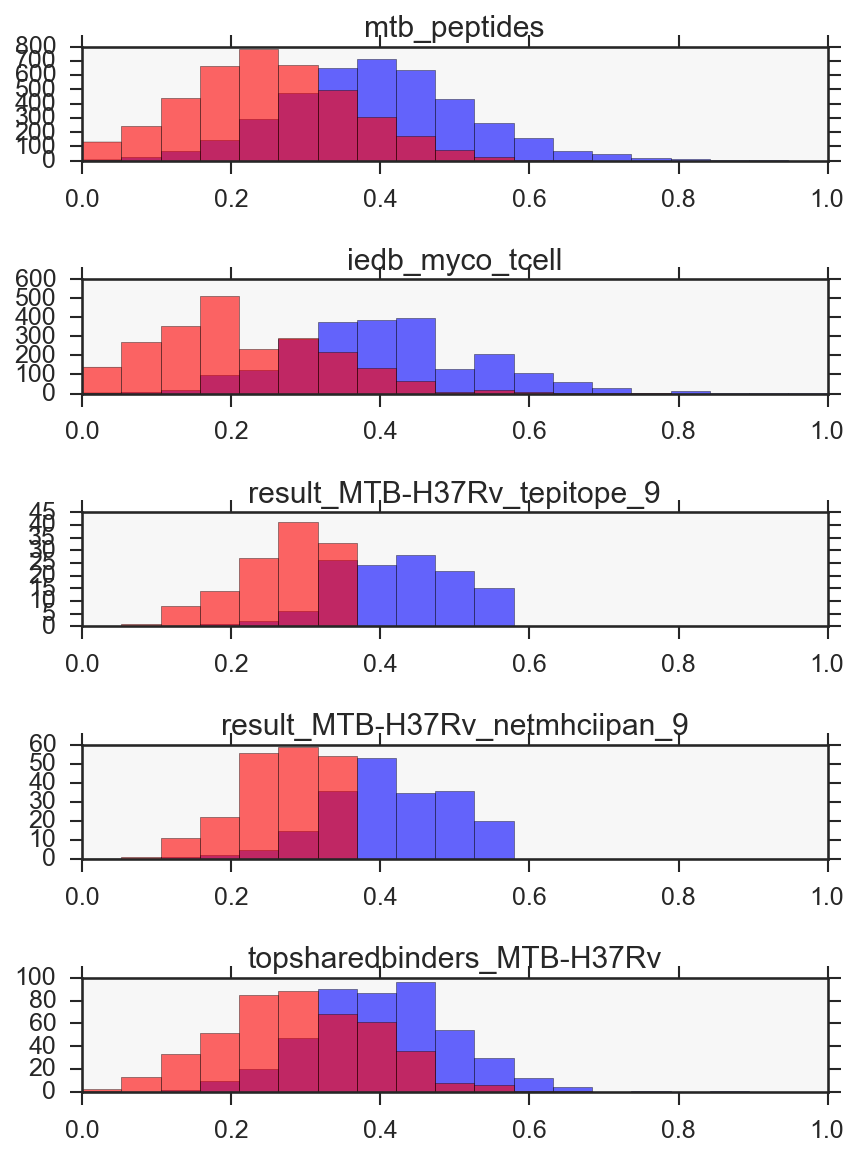

In [45]:
EpitopePipeline=reload(EpitopePipeline)
EpitopePipeline.analysePeptideAAContent()
#EpitopePipeline.analyseAminoAcids()

In [5]:
#reload final lists from files to avoid recalculation
final1 = pd.read_csv('result_MTB-H37Rv_netmhciipan_final.csv',index_col=0)
final2 = pd.read_csv('result_MTB-H37Rv_tepitope_final.csv',index_col=0)
final3 = pd.read_csv('topsharedbinders_final.csv',index_col=0)

In [48]:
#get final lists, randomise and save to excel sheets
n=96
lcols=['locus_tag','mbname','peptide'] #cols for excel file
f1 = final1[:n]
f1['method']='cl_tepitopepan'
f2 = final2[:n]
f2['method']='cl_netmhciipan'
f3 = final3[:n]
f3['method']='topsharedbinders'

plist = pd.concat([f1,f2,f3]).reset_index(drop=True)

#randomized list
np.random.seed(seed=8) #nb use same seed 
plist = plist.reindex(np.random.permutation(plist.index))
plist.to_csv('peptide_lists.csv') 

writer = pd.ExcelWriter('peptide_lists.xls')
chunks = np.array_split(plist.index, 3)
i=1
for c in chunks:
    plist.ix[c][lcols].to_excel(writer,'list'+str(i))
    i+=1
#also save by method for easy reference    
for i,g in plist.groupby('method'):
    g.sort()[lcols].to_excel(writer,'method'+str(i))
writer.save()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-

### get negative lists for benchmarking - the 'baseline' method:

27155 47370
95
overlaps for iedbmhc1_9
41 with overlapping binders
overlaps for iedbmhc1_11
49 with overlapping binders
            id               peptide
69  Mb2635c_69  LFSRKGVVTLEKNGLTEDDV
85   Mb1266_85  SGAWLGLFIGLVLGFFSPNP
12   Mb1687_12  TDLAEWLVRQGVPFRSAHEA
83  Mb1482c_83  FRRAPHLPFDATMTDELGTN
87   Mb0358_87  ARNGEVLVGQPAKNQAVTNV


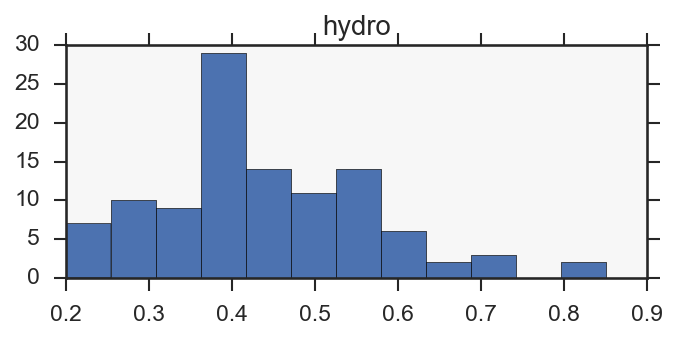

In [122]:
def getRandomNeg(b):
    np.random.seed(seed=8)
    br = b.reset_index(drop=True)
    bneg = br.ix[np.random.choice(br.index, 100)]    
    #use only single binders (no neighbours)?
    return bneg

#take lowest scoring?
#bneg = br1[-290:]
#take random ?

print len(b1), len(b4)
bn1 = getRandomNeg(b1)
bn4 = getRandomNeg(b4)
bneg = pd.concat([bn1,bn4])
#remove zero abundance data using srm data
bneg = bneg[bneg.name.isin(srm.locus_tag)]

def getpeptide(b, genome):
    #add fix for short peptides...
    b = bneg.merge(genome[['locus_tag','length','translation']],
                                left_on='name',right_on='locus_tag')

    b['start'] = b.apply(lambda x: x.pos-6 if x.pos>6 else 0,axis=1)
    b['end'] = b.apply(lambda x: x.pos+14 if x.pos>6 else 20,axis=1)
    b['peptide'] = b.apply(lambda x: x.translation[int(x.start):int(x.end)],axis=1)
    return b

bneg = getpeptide(bneg, genome)
bneg['hydro'] = bneg.apply(EpitopePipeline.getAAFraction,axis=1)
bneg['RVL'] = bneg.apply(lambda x: EpitopePipeline.getAAFraction(x,aas=['R','V','L']),axis=1)

mapping = pd.read_csv('mbovis_mapping_new.csv',usecols=[1,2,3,4])
bneg = bneg.merge(mapping,left_on='locus_tag',right_on='tbname',how='inner')
#remove <20mers
bneg = bneg[bneg.peptide.str.len()==20]
#filter hydro?
#bneg = bneg[bneg.hydro<=0.6]
bneg.hist('hydro',bins=12,figsize=(5,2),grid=False)

#remove any overlapping in positives!
#print bneg[bneg.columns[3:10]].merge(plist[['locus_tag','peptide']],on='locus_tag',how='inner')
bneg = bneg[-bneg.locus_tag.isin(plist.locus_tag)]
bneg = bneg.drop_duplicates('peptide')
bneg = bneg.reset_index()
bneg = bneg.reindex(np.random.permutation(bneg.index))
bneg.index = bneg.index+1
ind = bneg.index.astype(str)
bneg['id'] = bneg.mbname+'_'+ind

print len(bneg)
x=bneg.copy()
for i in mhc1binders:
    lbl = i+'_overlap'
    print 'overlaps for %s' %i
    x = EpitopePipeline.getOverlappingBinders(x, mhc1binders[i], label=lbl)   
bneg['mhc1overlaps'] = x.filter(regex="iedbmhc1_").sum(axis=1)

import csv
bneg.to_csv('negatives_list.csv',index=False, quoting=csv.QUOTE_NONNUMERIC)
writer = pd.ExcelWriter('negatives_list.xls')
lcols=['id','peptide']
#print bneg.peptide.str.len().value_counts()
#print len(bneg), len(bneg.peptide.unique())
print bneg[lcols][:5]
bneg[lcols].to_excel(writer,'negatives list')
writer.save()